# Collaboration and Competition

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### Benchmark model

First a benchmark model is implemented. Therefore the multi agent problem is reformulated into a single DDPG problem. There is only one policy which receives both state vectors and outputs the actions of both agents. Also the critic receives both states and the actions of both actors.

In [ ]:
class environment_single_wrapper():
    def __init__(self, env):
        self.env = env
        self.vector_observations = self.env
        self.brain_names = self.env.brain_names
        
    def reset(self, train_mode):
        self.env_info = self.env.reset(train_mode)
        return self
    
    def __getitem__(self, brain_name):
        self.env_info = self.env_info[brain_name]
        self.vector_observations = self.env_info.vector_observations.reshape(1,-1)
        self.rewards = np.array([sum(self.env_info.rewards)])
        self.local_done = np.array([max(self.env_info.local_done)])
        
        
        return self #self.env[brain_name]
    
    def step(self, action):
        self.env_info = self.env.step(action)
        return self

In [81]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic

In [82]:
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

In [83]:
from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.99, sigma=0.5, sigma_min=0.025)
#noise = GaussianNoise(action_size*2, 1, 1337, sigma=0.5, sigma_decay=0.99, sigma_min=0.025)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)

In [84]:
trainer = Trainer(environment_single_wrapper(env), ac)

In [ ]:
scores = trainer.train(8000)

In [75]:
noise.sample().shape

(1, 4)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

In [ ]:
## learning rate

In [89]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-5       # learning rate of the actor 
LR_CRITIC = 1e-5       # learning rate of the critic
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.99, sigma=0.5, sigma_min=0.025)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=0.5, sigma_decay=0.99, sigma_min=0.025)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

scores = trainer.train(6000)

Episode 0	Average Score: -0.01,   -0.01
Episode 100	Average Score: -0.01,   -0.01
Episode 200	Average Score: -0.01,   -0.01
Episode 300	Average Score: -0.01,   -0.01
Episode 400	Average Score: -0.01,   -0.01
Episode 500	Average Score: -0.01,   -0.01
Episode 600	Average Score: -0.01,   -0.01
Episode 700	Average Score: -0.01,   -0.01
Episode 800	Average Score: -0.01,   -0.01
Episode 900	Average Score: -0.01,   -0.01
Episode 1000	Average Score: -0.01,   -0.01
Episode 1100	Average Score: -0.01,   -0.01
Episode 1200	Average Score: -0.01,   -0.01
Episode 1300	Average Score: -0.01,   -0.01
Episode 1400	Average Score: -0.01,   -0.01
Episode 1500	Average Score: -0.01,   -0.01
Episode 1600	Average Score: 0.00,   -0.011
Episode 1700	Average Score: 0.02,   0.0911
Episode 1800	Average Score: 0.01,   -0.011
Episode 1900	Average Score: -0.00,   -0.01
Episode 2000	Average Score: -0.01,   -0.01
Episode 2100	Average Score: -0.01,   -0.01
Episode 2200	Average Score: -0.01,   -0.01
Episode 2300	Average Sc

KeyboardInterrupt: 

In [ ]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.99, sigma=0.5, sigma_min=0.025)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=0.5, sigma_decay=0.99, sigma_min=0.025)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

scores = trainer.train(6000)

In [ ]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-3       # learning rate of the actor 
LR_CRITIC = 1e-3       # learning rate of the critic
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.99, sigma=0.5, sigma_min=0.025)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=0.5, sigma_decay=0.99, sigma_min=0.025)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

scores = trainer.train(6000)

In [ ]:
## sigma

In [90]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.999, sigma=0.5, sigma_min=0.05)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=1.0, sigma_decay=0.999, sigma_min=0.05)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

scores = trainer.train(6000)

Episode 0	Average Score: -0.01,   -0.01
Episode 100	Average Score: 0.01,   -0.01
Episode 200	Average Score: -0.01,   -0.01
Episode 300	Average Score: -0.01,   -0.01
Episode 400	Average Score: -0.01,   -0.01
Episode 500	Average Score: -0.01,   -0.01
Episode 600	Average Score: -0.00,   -0.01
Episode 700	Average Score: -0.00,   -0.01
Episode 800	Average Score: 0.00,   -0.011
Episode 900	Average Score: -0.00,   -0.01
Episode 1000	Average Score: -0.00,   -0.01
Episode 1100	Average Score: 0.01,   -0.011
Episode 1200	Average Score: 0.01,   -0.011
Episode 1300	Average Score: -0.00,   -0.01
Episode 1400	Average Score: -0.00,   -0.01
Episode 1500	Average Score: -0.01,   -0.01
Episode 1600	Average Score: 0.00,   -0.011
Episode 1700	Average Score: 0.01,   -0.011
Episode 1800	Average Score: 0.01,   0.0911
Episode 1900	Average Score: 0.01,   -0.011
Episode 2000	Average Score: 0.02,   -0.011
Episode 2100	Average Score: 0.01,   -0.011
Episode 2200	Average Score: 0.00,   0.0901
Episode 2300	Average Sco

In [ ]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.98            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.999, sigma=0.5, sigma_min=0.025)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=1.0, sigma_decay=0.999, sigma_min=0.05)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

scores = trainer.train(6000)

Episode 0	Average Score: -0.01,   -0.01
Episode 100	Average Score: -0.01,   -0.01
Episode 200	Average Score: -0.01,   -0.01
Episode 300	Average Score: 0.00,   -0.011
Episode 400	Average Score: 0.01,   -0.011
Episode 500	Average Score: 0.00,   -0.011
Episode 600	Average Score: 0.01,   -0.011
Episode 700	Average Score: 0.02,   -0.011
Episode 800	Average Score: 0.01,   0.0911
Episode 900	Average Score: 0.02,   -0.01
Episode 1000	Average Score: 0.05,   0.09
Episode 1100	Average Score: -0.00,   -0.01
Episode 1200	Average Score: 0.02,   -0.011
Episode 1300	Average Score: 0.05,   -0.011
Episode 1400	Average Score: 0.01,   -0.011
Episode 1500	Average Score: 0.04,   0.091
Episode 1600	Average Score: 0.02,   0.091
Episode 1700	Average Score: 0.03,   0.0911
Episode 1800	Average Score: 0.03,   -0.01
Episode 1900	Average Score: 0.04,   0.091
Episode 2000	Average Score: 0.02,   -0.01
Episode 2100	Average Score: 0.04,   -0.01
Episode 2200	Average Score: 0.04,   -0.01
Episode 2300	Average Score: 0.05,

In [86]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.999, sigma=0.5, sigma_min=0.01)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=0.5, sigma_decay=0.99, sigma_min=0.025)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

scores = trainer.train(6000)

Episode 0	Average Score: -0.01,   -0.01
Episode 100	Average Score: 0.02,   -0.01
Episode 200	Average Score: -0.01,   -0.01
Episode 300	Average Score: -0.01,   -0.01
Episode 400	Average Score: -0.01,   -0.01
Episode 500	Average Score: 0.03,   -0.011
Episode 600	Average Score: 0.02,   -0.01
Episode 700	Average Score: 0.01,   -0.01
Episode 800	Average Score: 0.02,   0.0911
Episode 900	Average Score: 0.02,   -0.011
Episode 1000	Average Score: 0.04,   -0.01
Episode 1100	Average Score: 0.06,   0.091
Episode 1200	Average Score: 0.08,   0.191
Episode 1300	Average Score: 0.05,   -0.01
Episode 1400	Average Score: 0.02,   0.091
Episode 1500	Average Score: 0.01,   -0.01
Episode 1600	Average Score: 0.01,   -0.011
Episode 1700	Average Score: 0.02,   -0.01
Episode 1800	Average Score: 0.00,   -0.011
Episode 1900	Average Score: 0.01,   -0.01
Episode 2000	Average Score: 0.04,   -0.01
Episode 2100	Average Score: 0.02,   0.091
Episode 2200	Average Score: 0.01,   -0.01
Episode 2300	Average Score: 0.00,   -

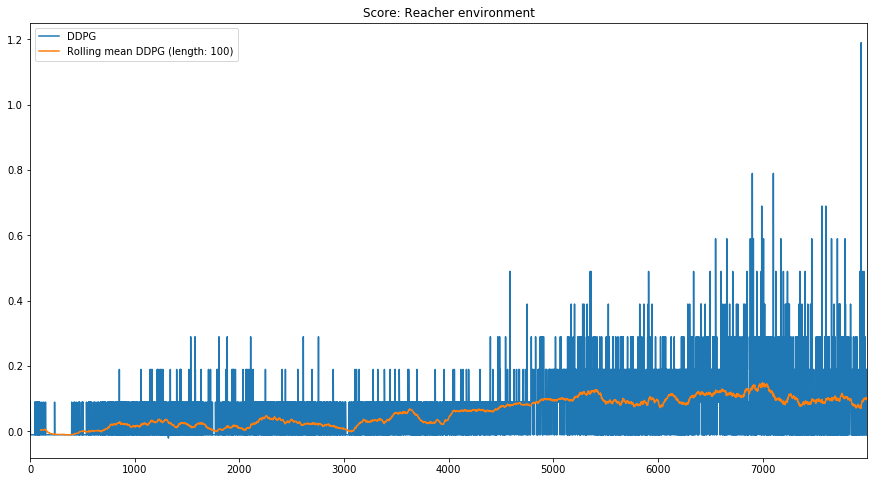

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

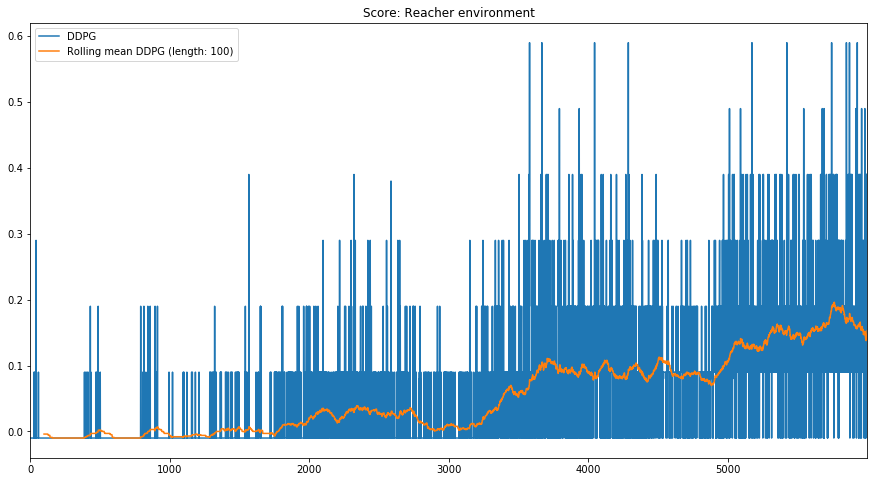

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

In [116]:
scores = trainer.train(4000)

E:\github\maddpg\agent.py:114: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 0	Average Score: -0.01,   -0.01
Episode 100	Average Score: 0.32,   0.19
Episode 200	Average Score: 0.25,   0.091
Episode 300	Average Score: 0.10,   0.291
Episode 400	Average Score: 0.35,   0.991
Episode 500	Average Score: 0.10,   -0.01
Episode 600	Average Score: 0.13,   -0.01
Episode 700	Average Score: 0.12,   0.091
Episode 800	Average Score: 0.13,   -0.01
Episode 900	Average Score: 0.31,   0.491
Episode 1000	Average Score: 0.34,   0.29
Episode 1100	Average Score: 0.33,   0.291
Episode 1200	Average Score: 0.57,   -0.01
Episode 1300	Average Score: 0.88,   1.591
Episode 1400	Average Score: 0.60,   1.391
Episode 1500	Average Score: 1.20,   -0.01
Episode 1600	Average Score: 1.00,   0.391
Episode 1682	Average Score: 0.93,   0.291

KeyboardInterrupt: 

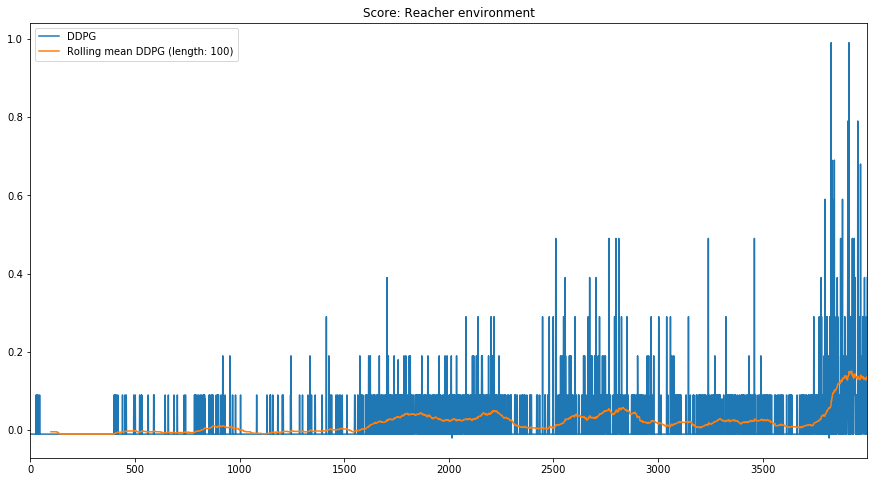

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

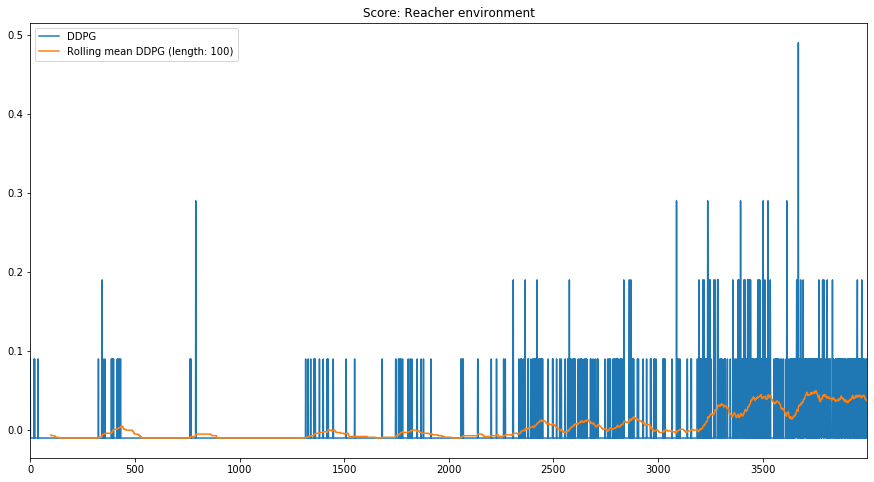

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

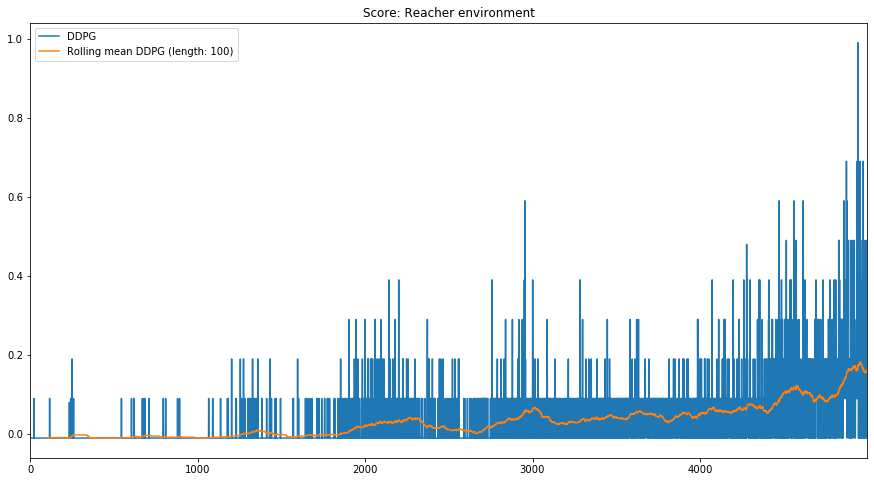

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

In [77]:
#import torch
actor = trainer.agent.actor_local#.state_dict()

import torch
#path = './coop_policy_network_tennis'
#actor = trainer.agent.actor_local.state_dict()
#torch.save(trainer.agent.actor_local.state_dict(), path)

#actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, lr=LR_ACTOR)
#actor.load_state_dict(torch.load(path))
#actor.eval()

In [78]:
env = environment_single_wrapper(env)

In [80]:
for i in range(1, 3):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = actor(torch.from_numpy(states).float()).cpu().data.numpy()
        #actions = trainer.agent.act(states)
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions[:2])[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: -0.009999999776482582
Score (max over agents) from episode 2: 0.19000000320374966


In [ ]:
rewards

In [ ]:
scores

In [ ]:
from agent import  DeterministicActorCriticAgent
from ounoise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size, num_agents, 1337, sigma_decay=0.999, sigma=0.75, sigma_min=0.75)
noise = GaussianNoise(action_size, num_agents, 1337, sigma=1.0, sigma_decay=0.995, sigma_min=0.05)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, ou_noise=noise)